## Utilization Rate

In [103]:
import pandas as pd

# Load the dataset (adjust the file path as needed)
file_path = r"D:\UNIVERSITY\SEMESTER 7\OR\Q2_OR.csv"
or_data = pd.read_csv(file_path)
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

# Display initial data insights
print(f"Total records in the dataset: {len(or_data)}")

# Define columns requiring datetime conversion
datetime_cols = ['Date', 'OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']

# Convert specified columns to datetime format
for col in datetime_cols:
    or_data[col] = pd.to_datetime(or_data[col], format='%m-%d-%Y %H:%M', errors='coerce')

# Ensure 'Date' column is formatted correctly
or_data['Date'] = pd.to_datetime(or_data['Date'], format='%m-%d-%Y', errors='coerce')

# Check for missing values after initial conversions
missing_values_initial = or_data.isnull().sum()

# Extract date from 'OR Schedule' to fill in the 'Date' column
or_data['Date'] = or_data['OR Schedule'].dt.date

# Check for missing values after fixing the 'Date' column
missing_values_after_fix = or_data.isnull().sum()

# Remove rows with missing timestamps in critical columns
required_cols = ['OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']
or_data_clean = or_data.dropna(subset=required_cols)

# Verify cleaned dataset
missing_values_cleaned = or_data_clean.isnull().sum()

# Calculate total available operating room (OR) time (24 hours per day assumption)
unique_dates = or_data_clean['Date'].nunique()
total_available_minutes = unique_dates * 24 * 60

# Calculate utilized time based on procedure durations
or_data_clean['Actual Duration (min)'] = (
    (or_data_clean['End Time'] - or_data_clean['Start Time']).dt.total_seconds() / 60
)
total_utilized_minutes = or_data_clean['Actual Duration (min)'].sum()

# Compute overall utilization rate
overall_utilization = (total_utilized_minutes / total_available_minutes) * 100
print(f"Overall Utilization Rate: {overall_utilization:.2f}%")

# Group data by week to analyze weekly utilization
or_data_clean['Week'] = or_data_clean['Date'].apply(lambda x: x.isocalendar()[1])
weekly_utilization = (
    or_data_clean.groupby('Week')
    .agg({'Actual Duration (min)': 'sum'})
    .reset_index()
)

# Add total available weekly time and calculate utilization rates
weekly_utilization['Weekly Available Time (min)'] = 7 * 24 * 60  # 7 days, 24 hours each
weekly_utilization['Utilization Rate (%)'] = (
    (weekly_utilization['Actual Duration (min)'] / weekly_utilization['Weekly Available Time (min)']) * 100
)

# Display results
print("Weekly Utilization Rates:\n", weekly_utilization)


Total records in the dataset: 2174
Overall Utilization Rate: 110.33%
Weekly Utilization Rates:
    Week  Actual Duration (min)  Weekly Available Time (min)  \
0     1                 8048.0                        10080   
1     2                 4615.0                        10080   
2     5                 6383.0                        10080   
3     6                 7857.0                        10080   
4     9                 6289.0                        10080   
5    10                 8114.0                        10080   

   Utilization Rate (%)  
0             79.841270  
1             45.783730  
2             63.323413  
3             77.946429  
4             62.390873  
5             80.496032  


The overall utilization rate is approximately 110.33%, suggesting potential overuse or instances of double-booking in the dataset.

The weekly utilization rates are as follows:
- **Week 1**: 79.84%
- **Week 2**: 45.78%
- **Week 5**: 63.32%
- **Week 6**: 77.95%
- **Week 9**: 62.39%
- **Week 10**: 80.50%


## Workflow Delays Analysis :

In [104]:
data = pd.read_csv(r"D:\UNIVERSITY\SEMESTER 7\OR\Q2_OR.csv")

# converting relevant columns to datetime
datetime_columns = ['Date', 'OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']
for col in datetime_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce', format='%m-%d-%Y %H:%M')

# Remove rows where any essential time columns are missing
data_clean = data.dropna(subset=['OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']).copy()

# Calculate time differences between key stages
data_clean['Schedule to Wheels In (min)'] = (data_clean['Wheels In'] - data_clean['OR Schedule']).dt.total_seconds() / 60
data_clean['Wheels In to Start (min)'] = (data_clean['Start Time'] - data_clean['Wheels In']).dt.total_seconds() / 60
data_clean['Start to End (min)'] = (data_clean['End Time'] - data_clean['Start Time']).dt.total_seconds() / 60
data_clean['End to Wheels Out (min)'] = (data_clean['Wheels Out'] - data_clean['End Time']).dt.total_seconds() / 60

# Calculate average delays and standard deviations for each stage
workflow_delay = data_clean[['Schedule to Wheels In (min)', 'Wheels In to Start (min)', 'Start to End (min)', 'End to Wheels Out (min)']].describe()
print(workflow_delay)

       Schedule to Wheels In (min)  Wheels In to Start (min)  \
count                   915.000000                915.000000   
mean                     35.156284                 21.459016   
std                      38.338791                  6.495345   
min                     -55.000000                  3.000000   
25%                       5.000000                 18.000000   
50%                      25.000000                 23.000000   
75%                      58.000000                 25.000000   
max                     210.000000                 45.000000   

       Start to End (min)  End to Wheels Out (min)  
count          915.000000               915.000000  
mean            45.143169                12.652459  
std             26.600296                 2.743100  
min             12.000000                 3.000000  
25%             27.000000                11.000000  
50%             35.000000                13.000000  
75%             58.000000                14.000000  



The delays observed in the workflow stages are summarized below:

- **Schedule to Wheels In**:  
  - Average Delay: 35.16 minutes  
  - Standard Deviation: 38.34 minutes  

- **Wheels In to Start**:  
  - Average Delay: 21.46 minutes  
  - Standard Deviation: 6.50 minutes  

- **Start to End**:  
  - Average Duration: 45.14 minutes  
  - Standard Deviation: 26.60 minutes  

- **End to Wheels Out**:  
  - Average Delay: 12.65 minutes  
  - Standard Deviation: 2.74 minutes  


## Booking Accuracy Analysis:

In [110]:
# Converting relevant columns to datetime
d_c = ['Date', 'OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']
data[d_c] = data[d_c].apply(pd.to_datetime, errors='coerce', format='%m-%d-%Y %H:%M')
data_clean = data.dropna(subset=['OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']).copy()
data_clean['Actual Duration (min)'] = (data_clean['End Time'] - data_clean['Start Time']).dt.total_seconds() / 60
data_clean['Booking Accuracy (min)'] = data_clean['Booked Time (min)'] - data_clean['Actual Duration (min)']
# describing booking accuracy
booking_accuracy_statistics = data_clean['Booking Accuracy (min)'].describe()
print("Booking Accuracy Statistics:")
print(booking_accuracy_statistics)

Booking Accuracy Statistics:
count    915.000000
mean      31.561749
std       13.578980
min       -3.000000
25%       24.000000
50%       30.000000
75%       35.000000
max      128.000000
Name: Booking Accuracy (min), dtype: float64


The analysis of booking accuracy reveals the following:

- **Mean Booking Accuracy**: 31.56 minutes (indicating overbooking)  
- **Standard Deviation**: 13.58 minutes  
- **Range**: -3 to 128 minutes  

On average, the booked time exceeds the actual procedure duration by approximately 31.56 minutes, suggesting a trend of overbooking in the system.

## Overall Utilization Rate:

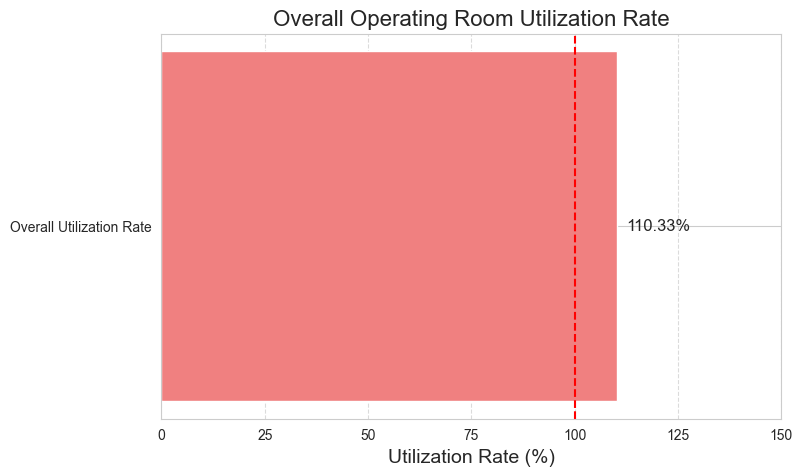

In [106]:
import matplotlib.pyplot as plt

# Plotting overall utilization rate with different style
plt.figure(figsize=(8, 5))
plt.barh(['Overall Utilization Rate'], [overall_utilization], color='lightcoral')

# Adding a horizontal line at 100% for comparison
plt.axvline(100, color='red', linestyle='--', label='100% Target')

# Adding annotations to the bars
for index, value in enumerate([overall_utilization]):
    plt.text(value + 2, index, f'{value:.2f}%', va='center', ha='left', fontsize=12)

# Customize labels and title
plt.xlabel('Utilization Rate (%)', fontsize=14)
plt.title('Overall Operating Room Utilization Rate', fontsize=16)
plt.xlim(0, 150)

# Customize ticks and grid
plt.xticks(range(0, 151, 25))
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


The overall utilization rate is around 110.33%, suggesting possible overuse or inefficiencies in scheduling.

## Weekly OR utilization rates:

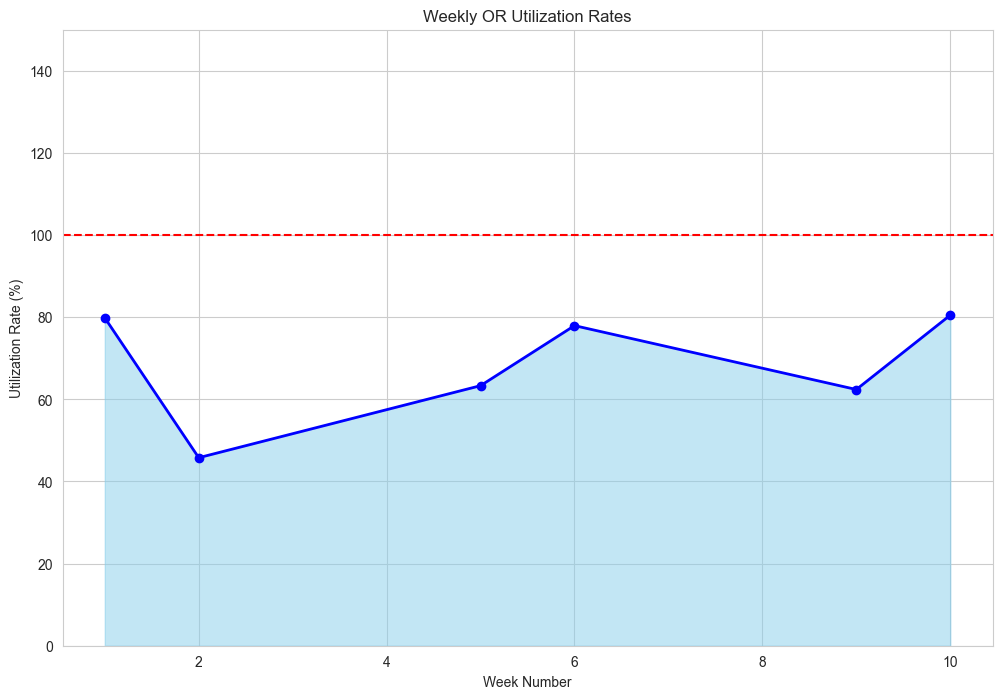

In [107]:
# Plotting weekly utilization rates using an area plot
plt.figure(figsize=(12, 8))
plt.fill_between(weekly_utilization['Week'], weekly_utilization['Utilization Rate (%)'], color='skyblue', alpha=0.5)
plt.plot(weekly_utilization['Week'], weekly_utilization['Utilization Rate (%)'], marker='o', color='b', linewidth=2)
plt.xlabel('Week Number')
plt.ylabel('Utilization Rate (%)')
plt.title('Weekly OR Utilization Rates')
plt.axhline(100, color='r', linestyle='--')
plt.ylim(0, 150)
plt.grid(True)
plt.show()


The weekly utilization rates fluctuate considerably, ranging from a high of 80.50% in some weeks to a low of 45.78% in others.

## Workflow Delays:

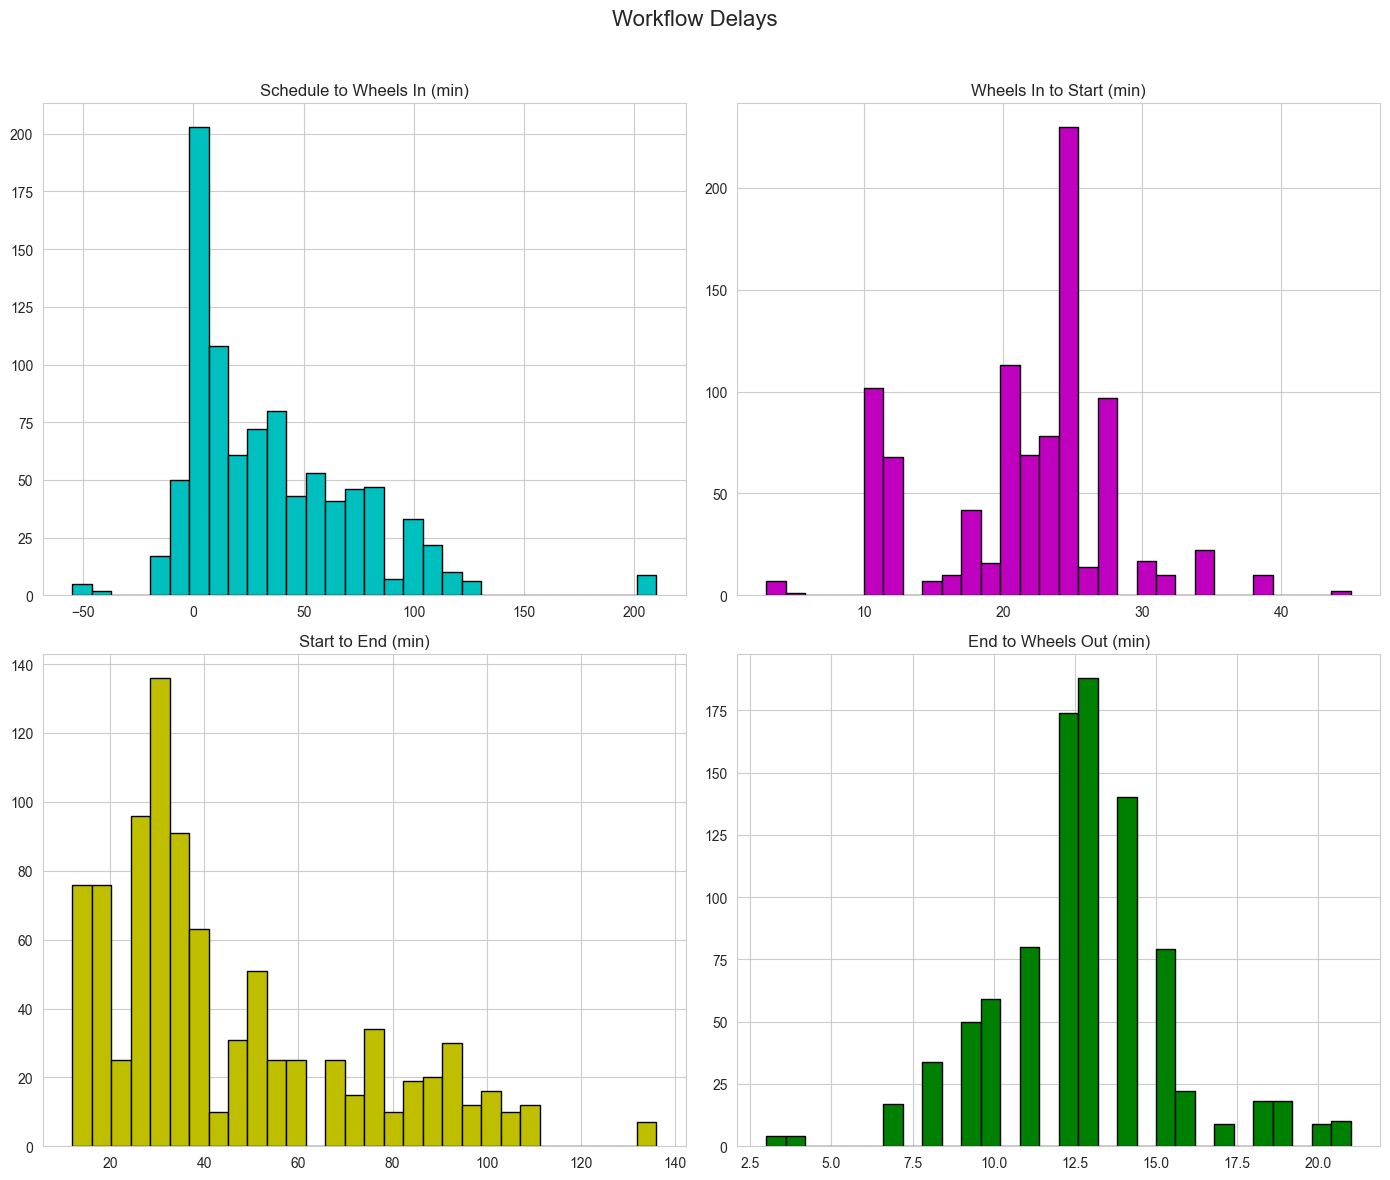

In [108]:
 #converting relevant columns to datetime
d_c = ['Date', 'OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']
for col in d_c:
    data[col] = pd.to_datetime(data[col], errors='coerce', format='%m-%d-%Y %H:%M')
data_clean = data.dropna(subset=['OR Schedule', 'Wheels In', 'Start Time', 'End Time', 'Wheels Out']).copy()
data_clean['Schedule to Wheels In (min)'] = (data_clean['Wheels In'] - data_clean['OR Schedule']).dt.total_seconds() / 60
data_clean['Wheels In to Start (min)'] = (data_clean['Start Time'] - data_clean['Wheels In']).dt.total_seconds() / 60
data_clean['Start to End (min)'] = (data_clean['End Time'] - data_clean['Start Time']).dt.total_seconds() / 60
data_clean['End to Wheels Out (min)'] = (data_clean['Wheels Out'] - data_clean['End Time']).dt.total_seconds() / 60
# Ploting workflow delays
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Workflow Delays', fontsize=16)
axes[0, 0].hist(data_clean['Schedule to Wheels In (min)'], bins=30, color='c', edgecolor='black')
axes[0, 0].set_title('Schedule to Wheels In (min)')
axes[0, 1].hist(data_clean['Wheels In to Start (min)'], bins=30, color='m', edgecolor='black')
axes[0, 1].set_title('Wheels In to Start (min)')
axes[1, 0].hist(data_clean['Start to End (min)'], bins=30, color='y', edgecolor='black')
axes[1, 0].set_title('Start to End (min)')
axes[1, 1].hist(data_clean['End to Wheels Out (min)'], bins=30, color='g', edgecolor='black')
axes[1, 1].set_title('End to Wheels Out (min)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The following delays have been observed across the various workflow stages:

- **Schedule to Wheels In**: The average delay is 35.16 minutes, with some cases extending up to 210 minutes.
- **Wheels In to Start**: The average delay is 21.46 minutes.
- **Start to End**: The average duration is 45.14 minutes.
- **End to Wheels Out**: The average duration is 12.65 minutes.

## Distribution of booking Accuracy:

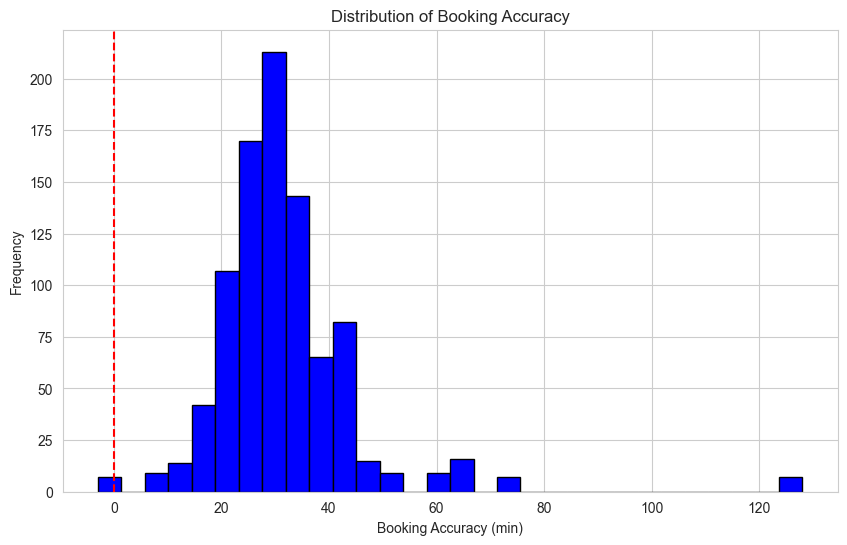

In [111]:
# Ploting booking accuracy
plt.figure(figsize=(10, 6))
plt.hist(data_clean['Booking Accuracy (min)'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Booking Accuracy (min)')
plt.ylabel('Frequency')
plt.title('Distribution of Booking Accuracy')
plt.axvline(0, color='r', linestyle='--')
plt.grid(True)
plt.show()

There is a tendency for overbooking, as the booked time surpasses the actual duration by an average of 31.56 minutes.

## Cancellation rated by specialty:

C:\Users\Rakhil\AppData\Local\Temp\ipykernel_3084\170707227.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


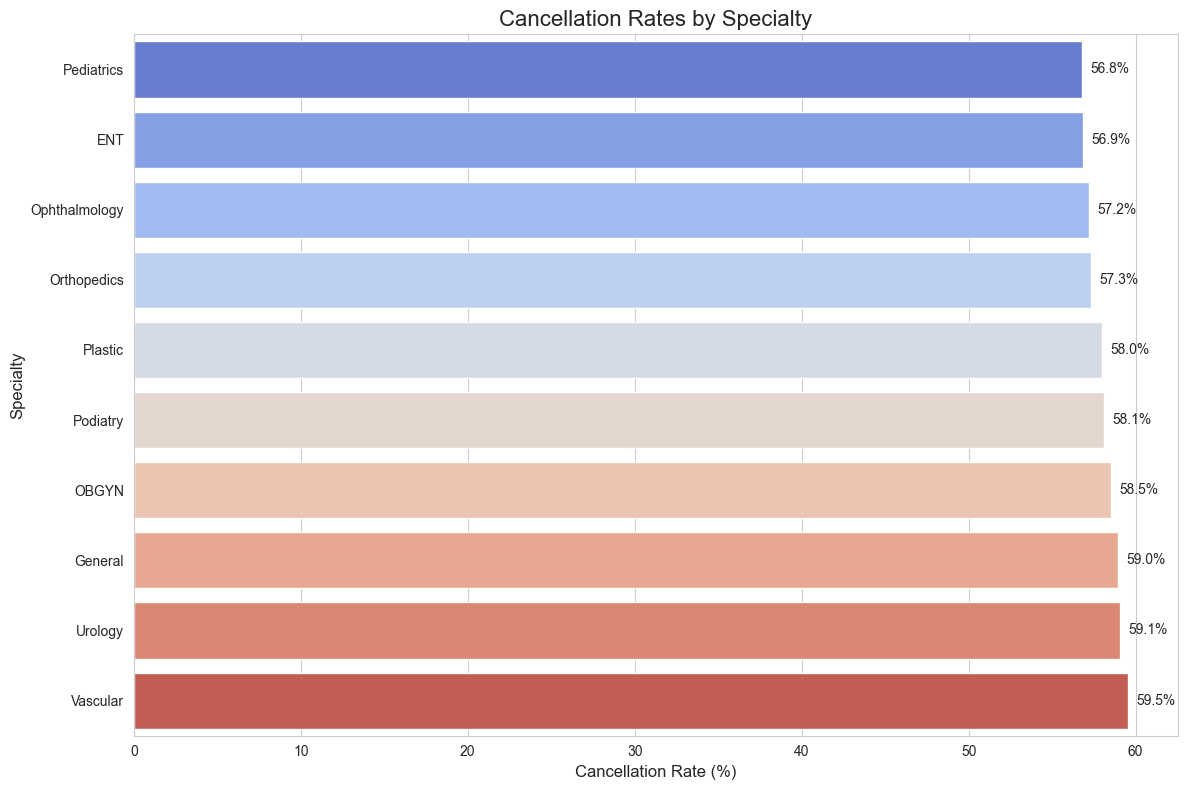

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sorting the cancellation rate for better visualization
cancellation_by_specialty_sorted = cancellation_by_specialty.sort_values()

# Set up the style and size of the plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create the bar plot
sns.barplot(
    x=cancellation_by_specialty_sorted,
    y=cancellation_by_specialty_sorted.index,
    palette="coolwarm"
)

# Add labels and title
plt.xlabel('Cancellation Rate (%)', fontsize=12)
plt.ylabel('Specialty', fontsize=12)
plt.title('Cancellation Rates by Specialty', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add percentage labels to the bars
for index, value in enumerate(cancellation_by_specialty_sorted):
    plt.text(value + 0.5, index, f'{value:.1f}%', va='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


## Booking Accuracy by speciality and Procedure:

C:\Users\Rakhil\AppData\Local\Temp\ipykernel_3084\226741468.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


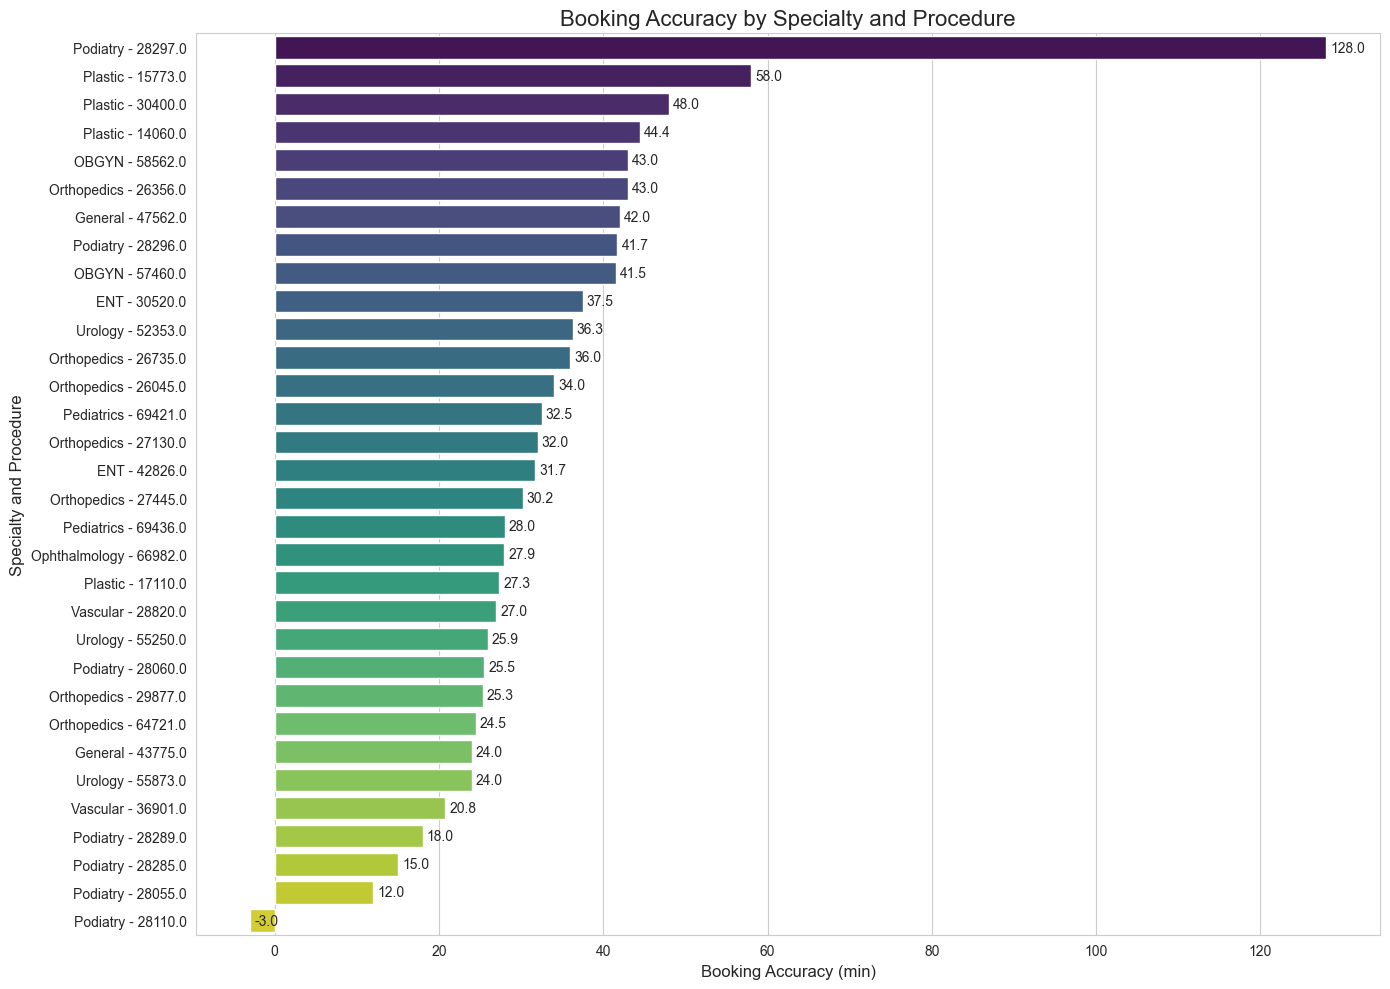

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a combined column for Specialty and Procedure for better grouping
segmented_data['Specialty_Procedure'] = segmented_data['Service'] + ' - ' + segmented_data['CPT Code'].astype(str)

# Sort the data for better visualization
booking_accuracy_sorted = segmented_data.sort_values(by='Booking Accuracy (min)', ascending=False)

# Set up the style and figure
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

# Create a bar plot
sns.barplot(
    x='Booking Accuracy (min)', 
    y='Specialty_Procedure', 
    data=booking_accuracy_sorted, 
    palette='viridis'
)

# Add labels and title
plt.xlabel('Booking Accuracy (min)', fontsize=12)
plt.ylabel('Specialty and Procedure', fontsize=12)
plt.title('Booking Accuracy by Specialty and Procedure', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add labels to each bar
for index, value in enumerate(booking_accuracy_sorted['Booking Accuracy (min)']):
    plt.text(value + 0.5, index, f'{value:.1f}', va='center', fontsize=10)

# Tighten layout and display the plot
plt.tight_layout()
plt.show()


Booking accuracy shows considerable variation across specialties and procedures. Positive values reflect overbooking, where the booked time exceeds the actual procedure duration, while negative values indicate underbooking, where the booked time falls short of the actual time required.

## Cancellation rates by specialty and procedure:

C:\Users\Rakhil\AppData\Local\Temp\ipykernel_3084\440104971.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


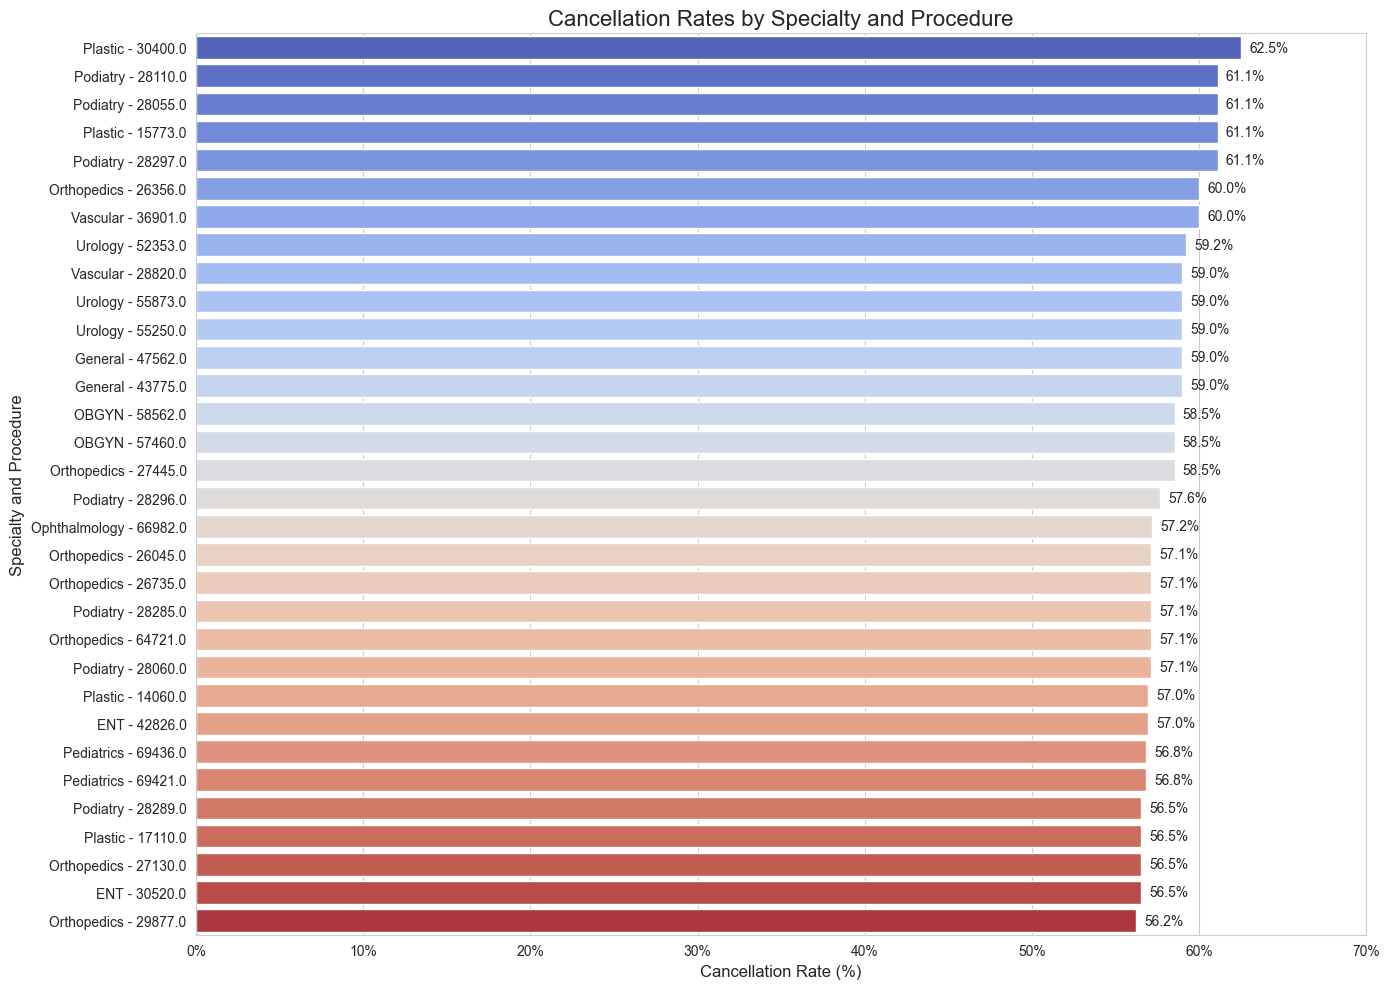

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a combined column for Specialty and Procedure
segmented_data['Specialty_Procedure'] = segmented_data['Service'] + ' - ' + segmented_data['CPT Code'].astype(str)

# Sort the data by cancellation rates
cancellation_rates_sorted = segmented_data.sort_values(by='Cancelled', ascending=False)

# Set up the style and size of the plot
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

# Create the bar plot
sns.barplot(
    x='Cancelled', 
    y='Specialty_Procedure', 
    data=cancellation_rates_sorted, 
    palette='coolwarm'
)

# Convert cancellation rate to percentages for display
plt.xlabel('Cancellation Rate (%)', fontsize=12)
plt.ylabel('Specialty and Procedure', fontsize=12)
plt.title('Cancellation Rates by Specialty and Procedure', fontsize=16)

# Get current ticks and format them as percentages
current_ticks = plt.xticks()[0]
plt.xticks(ticks=current_ticks, labels=[f'{x * 100:.0f}%' for x in current_ticks], fontsize=10, rotation=0)

# Adjust y-ticks for better readability
plt.yticks(fontsize=10)

# Add percentage labels to each bar
for index, value in enumerate(cancellation_rates_sorted['Cancelled']):
    plt.text(value + 0.005, index, f'{value * 100:.1f}%', va='center', fontsize=10)

# Tighten the layout and display the plot
plt.tight_layout()
plt.show()


Cancellation rates vary widely across specialties and procedures. Elevated cancellation rates may suggest problems with scheduling, patient readiness, or other logistical difficulties.



### Findings

1. **Overall Utilization Rate**: The overall utilization rate is approximately 110.33%, which suggests potential overuse or inefficiencies in the scheduling process.
   
2. **Weekly Utilization Rates**: Utilization rates fluctuate significantly across weeks, with some weeks reaching up to 80.50% utilization, while others dip as low as 45.78%.
   
3. **Workflow Delays**: Several workflow delays have been identified:
   - *Schedule to Wheels In*: Average delay of 35.16 minutes, with some instances extending to 210 minutes.
   - *Wheels In to Start*: Average delay of 21.46 minutes.
   - *Start to End*: Average duration of 45.14 minutes.
   - *End to Wheels Out*: Average duration of 12.65 minutes.
   
4. **Booking Accuracy**: There is a tendency for overbooking, with the booked time exceeding the actual procedure duration by an average of 31.56 minutes.

